# AI in Industry project
Ildebrando Simeoni

Davide Femia

Riccardo Falco

Vincenzo Collura

A stochastic differential equation (SDE) is a differential equation in which one or more of the terms is a stochastic process, resulting in a solution which is also a stochastic process. SDEs are used to model various phenomena such as stock prices or physical systems subject to thermal fluctuations. Typically, SDEs contain a variable which represents random white noise calculated as the derivative of Brownian motion or the Wiener process.

A stochastic differential equation, usually called SDE, is a stochastic dynamical
system of the form


dXt = a(Xt, t) dt + b(Xt, t) dWt . (1)


A diffusion satisfies the SDE (1) if Gt = a(Xt, t) and Ft = b(Xt, t). The
coefficients are a(x, t), which is the drift coefficient, and b(x, t), which is the noise coefficient

 An SDE is a model with a deterministic part, which we call “drift” here,
and noise, modeled by bdW.

Intro to our problem and description of the model (Tavecchio et al)

𝑑𝑋 = 𝜃(𝜇 − 𝑋)𝑑𝑡 + 𝜎𝑋𝑑𝑊𝑡 , (0.1)

specified by the parameters 𝜃 (the inverse of the time scale of the drift term), 𝜇 (equilibrium
value for 𝑋) and 𝜎 (coefficient of the stochastic term).
Eq. 0.1 describes a quite simple underlying dynamics: the deterministic (drift) term pushes
the system toward an equilibrium value 𝜇, while the evolution is disturbed by a random noise
whose amplitude is proportional to the actual value of 𝑋. Hence, high states, characterized
by large 𝑋, will also display the largest fluctuations.

SDE are commonly solved by using standard numerical schemes. For the specific SDE we are
considering, the Milstein method is appropriate (see e.g.). Applying this method we obtain the
following:

𝑋𝑖+1 = 𝑋𝑖 + 𝜃(1 − 𝑥𝑖)Δ𝑡 + 𝜎𝑊𝑖𝑋𝑖
√
Δ𝑡 +
1
2
𝜎2𝑋𝑖Δ𝑡(𝑊2
𝑖 − 1) (0.2)

where 𝑊𝑖 is a random variable chosen from a normal distribution with mean 0 and standard
deviation 1.

## Utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import layers
import keras.callbacks

2023-02-11 14:40:16.518767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

O calcoliamo noi il Milnstein approximation della SDE o usiamo (come nella prossima cella) l'approssimazione già fornita

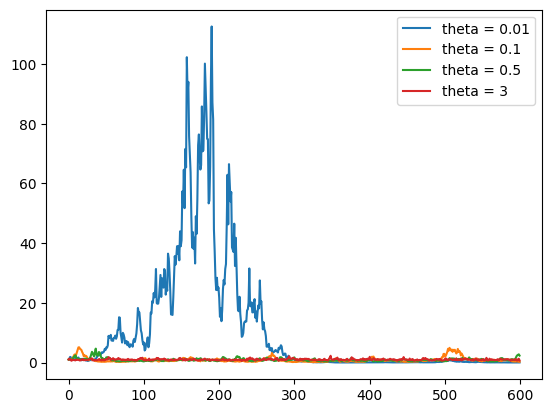

In [2]:
#Quale valore devo dare a delta_t ?
thetas = [0.01, 0.1, 0.5, 3]
results = []
for theta in thetas:
    sigma = 0.5
    X = np.zeros(600)
    X[0] = 1
    delta_t = 0.2
    W = np.zeros(600)
    W[0] = 0
    for i in range(0,599):
        W[i] = np.random.normal(0, 1)
        X[i+1] = X[i] + theta*(1 - X[i])*delta_t + sigma*W[i]*X[i]*np.sqrt(delta_t) + 0.5*sigma**2*X[i]*delta_t*(W[i]**2 - 1)
    plt.plot(X, label = "theta = " + str(theta))
    results.append(X)
plt.legend()
plt.show()

In [3]:
df = pd.DataFrame(results, index = ['Light value 0.01', 'Light value 0.1', 'Light value 0.5', 'Light value 3']).T
df['Time'] = df.index

In [4]:
df

,Light value 0.01,Light value 0.1,Light value 0.5,Light value 3,Time
0,1.000000,1.000000,1.000000,1.000000,0
1,1.315284,1.123116,0.921403,1.315722,1
2,1.884170,1.036205,1.042137,1.061265,2
3,1.693964,0.969695,1.088975,0.733693,3
4,1.193319,1.137368,0.977507,0.594107,4
...,...,...,...,...,...
595,0.026121,0.388541,2.098406,0.715282,595
596,0.029941,0.377540,2.426313,0.679450,596
597,0.024647,0.281775,2.583084,1.090943,597
598,0.027944,0.296154,2.745884,1.273005,598


In [5]:
df.describe()

,Light value 0.01,Light value 0.1,Light value 0.5,Light value 3,Time
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,10.875948,0.855553,0.900769,0.988476,299.500000
std,19.952561,0.863232,0.494892,0.233842,173.349358
min,0.011000,0.129249,0.312091,0.499602,0.000000
25%,0.067470,0.352278,0.594930,0.820713,149.750000
50%,0.714331,0.584145,0.783512,0.953167,299.500000
75%,13.585614,0.958067,1.050622,1.113742,449.250000
max,112.592802,5.086967,4.660942,2.257806,599.000000


## Prove

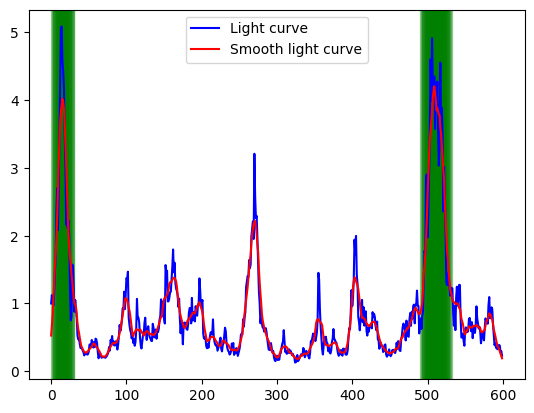

In [6]:
#Spot possible flares

x = df['Light value 0.1']
x = np.array(x)

# Define the threshold for identifying flares
threshold = x.mean() + 2*x.std()

# Smooth the light curve using a moving average
window = 10
x_smooth = np.convolve(x, np.ones(window)/window, mode='same')

# Initialize an array to store the flares
flares = []

# Identify the flares using the threshold test
for i in range(window, len(x)-window):
    if x_smooth[i] > threshold:
        # A flare is detected
        flare_start = i - window
        flare_end = i + window
        flares.append((flare_start, flare_end))

# Plot the light curve and the identified flares
plt.plot(x, 'b-', label='Light curve')
plt.plot(x_smooth, 'r-', label='Smooth light curve')
for flare in flares:
    plt.axvspan(flare[0], flare[1], color='g', alpha=0.3)
plt.legend()
plt.show()

In [7]:
import tensorflow as tf

# Light curve generated by the SDE
x = df['Light value']
x = np.array(x)

# Divide the light curve into training and test sets
split = int(0.8*len(x))
x_train, x_test = x[:split], x[split:]

# Define the neural network
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_test, x_test))

# Make predictions on the test set
x_pred = model.predict(x_test)

# Plot the light curve and the predictions
plt.plot(x_test, 'b-', label='Light curve')
plt.plot(x_pred, 'r-', label='Predictions')
plt.legend()
plt.show()

KeyError: 'Light value'

## Approaches

### Neuro-probabilistic

In [8]:
train_set = df[['Light value 3', 'Time']][0:400]
test_set = df[['Light value 3', 'Time']][400:]

In [9]:
train_set

,Light value 3,Time
0,1.000000,0
1,1.315722,1
2,1.061265,2
3,0.733693,3
4,0.594107,4
...,...,...
395,0.833347,395
396,1.127038,396
397,1.274244,397
398,1.005095,398


In [10]:
def build_nn_poisson_model(input_shape, hidden, loc_guess=0, scale_guess = 1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Gumbel(loc = loc_guess, scale = scale_guess)
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model

In [11]:
model = build_nn_poisson_model(input_shape=len(train_set), hidden=[])


2023-02-11 14:41:46.473200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


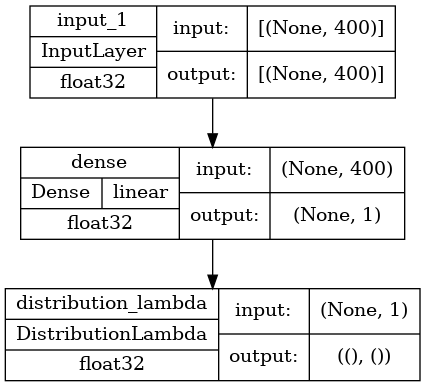

In [12]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
def train_nn_model(model, X, y, loss,
        verbose=0, patience=10,
        validation_split=0.0, **fit_params):
    # Compile the model
    model.compile(optimizer='Adam', loss=loss)
    # Build the early stop callback
    cb = []
    if validation_split > 0:
        cb += [callbacks.EarlyStopping(patience=patience,
            restore_best_weights=True)]
    # Train the model
    history = model.fit(X, y, callbacks=cb,
            validation_split=validation_split,
            verbose=verbose, **fit_params)
    return history

In [ ]:
def plot_training_history(history=None,
        figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    # if 'val_loss' in history.history.keys():
    #     plt.plot(history.history['val_loss'], label='val. loss')
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

In [ ]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
train_in = train_set['Light value 3']
train_out = train_set['Time']
history = train_nn_model(model, train_in, train_out, loss=negloglikelihood, validation_split=0.0, batch_size=32, epochs=30)
plot_training_history(history, figsize=(10,10))

ValueError: ignored

#### Error Analysis

### PINN

##Conclusions